In [199]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.nn.functional import grid_sample
import nibabel as nib
import os
from os.path import join
import numpy as np
import pandas as pd
from scipy.ndimage import zoom
#from models.densenet import DenseNet

In [131]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#Path to data
path_to_data = "G:\data\dose_matrices_updated_25_01_2023"
print(len(os.listdir(join(path_to_data, "nii"))))



cpu
3939


In [275]:
image = np.squeeze(np.asanyarray(nib.load('G:/data/dose_matrices_updated_25_01_2023/nii/newdosi_3_197708498_ID2013A.nii.gz').dataobj))[np.newaxis]
print(image.shape)

(1, 67, 70, 71)


In [276]:
image_cropped = image[0:1,2:66, 3:67, 3:67]
print(image_cropped.shape)

(1, 64, 64, 64)


In [277]:
class CustomDataset(Dataset):
  def __init__(self, annotations_file, path_to_dir, min_card_age, 
               training=False, validation=False, transform=None, target_transform=None):
    
    assert min_card_age == 40 or min_card_age == 50

    labels_csv = pd.read_csv(join(path_to_dir, annotations_file), sep=',')

    if training:
      self.img_labels = labels_csv[labels_csv[f'train_{min_card_age}'] == 1]
    elif validation:
      self.img_labels = labels_csv[labels_csv[f'val_{min_card_age}'] == 1]

    self.path_to_dir = path_to_dir
    self.img_dir = join(self.path_to_dir, 'nii')

    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):

    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx]["file_name"])
    image = np.squeeze(np.asanyarray(nib.load(img_path).dataobj))[np.newaxis]
    image_cropped = image[0:1,2:66, 3:67, 3:67]

    label = self.img_labels.iloc[idx]['Pathologie_cardiaque_3_new']

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)

    return image_cropped, label


In [264]:
#Config
batch_size = 4

In [278]:
training_data = CustomDataset("labels.csv", path_to_data, 40, training = True)
val_data = CustomDataset("labels.csv", path_to_data, 40, validation = True)

print(len(training_data), len(val_data))

train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True)
print('done')

input, label = next(iter(val_dataloader))
print(input.shape)

723 181
done
torch.Size([4, 1, 64, 64, 64])


### 1er modèle

In [6]:
class Net(nn.Module):
    def __init__(self, batch_size, hidden_units=200):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(batch_size*64*64*64, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x.float()

In [11]:
def test_our_model(val_dataloader, model):  # no arguments, literally all our variable our globals (not great but it's a notebook)
    # Put model in eval mode
    model.eval()  # to remove stuff like dropout that's only going to be in the training part

    # Setup test accuracy value
    test_acc = 0

    # Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for X_test, y_test in val_dataloader:  # majuscule à X car c'est une "matrice", et y un entier
            # 1. Forward pass
            # print(X_test.view(-1, 64*64*3).shape)
            # break
            X_flatten = X_test.flatten()
            model_output = model(X_flatten.float())

            # 2. Calculate and accumulate accuracy
            test_pred_label = model_output.argmax()
            test_acc += (test_pred_label == y_test).sum()  # True == 1, False == 0

    # Adjust metrics to get average loss and accuracy per batch
    test_acc = test_acc / (val_dataloader.batch_size*len(val_dataloader))
    print(test_acc.item())


In [12]:
model = Net(4,100)

In [13]:
print("Let's begin")
test_our_model(val_dataloader, model.float())  #ça marche

Let's begin
0.6944444179534912


In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(params=model.parameters(), lr=0.001)
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.1)

nbr_epochs: int = 3

In [16]:
from tqdm.auto import tqdm

In [17]:
print(len(train_dataloader))

180


In [18]:
def train(optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    for epoch in tqdm(range(nbr_epochs)):
        # Loop through data loader data batches
        for i, value in enumerate(train_dataloader):

            X, y = value[0], value[1]
            print(X.shape)
            
            # 1. Forward pass
            X_flatten = X.flatten()
            X_flatten = X_flatten.float()
            y_pred = model(X_flatten.float())
        
            print(y)
            print(y_pred)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred.float(), y.float())
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = y_pred.argmax()
            train_acc += (y_pred_class == y).sum()

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / (train_dataloader.batch_size * len(train_dataloader))
        train_acc = train_acc / (train_dataloader.batch_size * len(train_dataloader))
        print(
            f"epoch {epoch+1}/{nbr_epochs},"
            f" train_loss = {train_loss:.2e},"
            f" train_acc = {100*train_acc.item():.2f}%"
        )


In [38]:
train(optimizer_adam)

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([4, 64, 64, 64])
tensor([0, 0, 0, 0])
tensor([-0.0137,  0.0893], grad_fn=<AddBackward0>)


RuntimeError: size mismatch (got input: [2], target: [4])

In [17]:
print("Let's check")
test_our_model(val_dataloader, model.float())  #ça marche

Let's check
0.9777777791023254


In [19]:
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [20]:
print(training_data[0][0].shape)

(64, 64, 64)


In [84]:
class CNN_test(nn.Module):
    def __init__(self, out_channel):
        super(CNN_test, self).__init__()

        self.conv1 = nn.Sequential(
            #conv layer 1
            nn.Conv3d(1,out_channel, kernel_size=(3,3,3), padding=1),
            #nn.BatchNorm3d(out_channel),
            nn.ReLU())
            #nn.MaxPool3d((2,2,2)),

            #conv Layer 2
        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channel,out_channel*2,kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(out_channel*2),
            nn.ReLU())
            #nn.MaxPool3d((2,2,2)),

        self.conv3 = nn.Sequential(
            nn.Conv3d(out_channel*2, out_channel*3, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(out_channel*3),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(64*14*14, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 2)

        

    def forward(self, x):
        print(x.shape)
        x = self.conv1(x)
        print(x.shape)
        x = self.conv2(x)
        x = self.conv3(x)
        print(x.shape)
        x = x.view(-1, 64*64*64*4)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x

In [89]:
batch_size = 4
nbr_epochs = 5

model = CNN_test(4)

In [90]:
main_train_conv(nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=0.01))

torch.Size([4, 64, 64, 64])



RuntimeError: Given groups=1, weight of size [4, 1, 3, 3, 3], expected input[1, 4, 64, 64, 64] to have 1 channels, but got 4 channels instead

In [22]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    
        self.conv_layer1 = nn.Conv3d(2,4,kernel_size=3)
        self.pool = nn.MaxPool3d(4,3)
        self.conv_layer2 = nn.Conv3d(4,16,kernel_size=3)
        self.linear_layer1 = nn.Linear(2000, 100)
        self.linear_layer2 = nn.Linear(100,1)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_layer2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1,2000)
        x = F.relu(self.linear_layer1(x))
        x = F.relu(self.linear_layer2(x))
        return x

#### Training loop

In [26]:
import time

In [73]:
def main_train_conv(loss_fn, optimizer) -> None:
    """
    Train the model and modified the trained model inplace.
    """
    start_time_global = time.time()

    # Put model in train mode
    model.train()

    # Loop through data loader data batches
    for epoch in tqdm(range(5)):
        start_time_epoch = time.time()

        # Setup train loss and train accuracy values
        train_loss, train_acc = 0, 0

        for X, y in train_dataloader:

            # 2. Forward pass
            y_pred = model(X)

            # 3. Calculate and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 4. Optimizer zero grad
            optimizer.zero_grad()

            # 5. Loss backward
            loss.backward()

            # 6. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = y_pred.argmax(dim=1)
            train_acc += (y_pred_class == y).sum()

        

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / (batch_size * len(train_dataloader))
        train_acc = train_acc / (batch_size * len(train_dataloader))
        
        print(
            f"epoch {epoch+1}/{10},"
            f" train_loss = {train_loss:.2e},"
            f" train_acc = {100*train_acc.item():.2f}%,"
            f" time spent during this epoch = {time.time() - start_time_epoch:.2f}s,"
            f" total time spent = {time.time() - start_time_global:.2f}s"
        )

In [32]:
main_train_conv(nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=0.01))

RuntimeError: Given groups=1, weight of size [12, 1, 3, 3, 3], expected input[1, 4, 64, 64, 64] to have 1 channels, but got 4 channels instead

In [24]:
def accuracyFUNCTION (Predicted, Targets):          
    C=0
    for I in range(len(Targets)):
        if (Predicted[I] == Targets[I]):
            C+=1
    Accuracy =  C / float(len(Targets))
    print('Accuracy   = ', C ,'/', len(Targets))
    return(Accuracy)

In [26]:
itr = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(nbr_epochs):

    for i, (images, labels) in enumerate(train_dataloader):
        labels = Variable(labels.type(dtype=torch.float32))
        
        train = Variable(images.type(dtype=torch.float32).view(2,64,64,64))

        optimizer.zero_grad()

        outputs = model(train)

        outputs = outputs.type(dtype=torch.float32).view(-1)


        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        # Update parameters using SGD optimizer 
        optimizer.step()

        #calculate the accuracy using test data
        itr += 1
        if itr % 100 == 0:
            # Prepare a list of correct results and a list of anticipated results.     
            listLabels=[]
            listpredicted=[]
            # test_loader
            for images, labels in val_dataloader:

                test = Variable(images.type(dtype=torch.float32).view(2,64,64,64))
                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                outputs = outputs.type(dtype=torch.float32).view(-1)
                
                # used to convert the output to binary variables
                #predicted= one_hit_data(outputs) 

                # Create a list of predicted data
                predlist=[]
                for i in range(len(outputs)):
                    p = int(torch.argmax(outputs[i]))
                    predlist.append(p)

                
                listLabels+=(labels.tolist())
                listpredicted+=(predlist)

                
                # calculate Accuracy
            accuracy= accuracyFUNCTION(listpredicted, listLabels)
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(itr, loss.data, accuracy))

            # store loss and accuracy. They'll be required to print the curve.
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)

ValueError: Target size (torch.Size([2])) must be the same as input size (torch.Size([1]))

In [ ]:
import matplotlib.pyplot as plt

tensor([0., 0.])
['0', '0']
tensor([0., 0.])


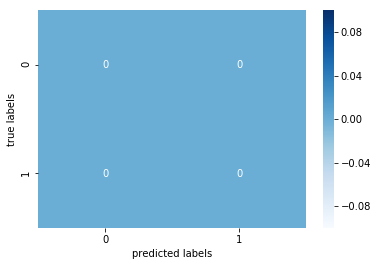

In [ ]:
predictionlist=[]
for i in range(len(outputs)):
    p = int(torch.argmax(outputs[i]))
    predictionlist.append(p)

labels1 = labels.view(-1)
print(labels1)
#labels1 = [str(x) for x in labels1]
predictionlist = [str(x) for x in predictionlist]
print(predictionlist)
print(labels1)
cm = confusion_matrix(labels1, predictionlist, labels = [0,1])


ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = plt.cm.Blues)
ax.set_xlabel("predicted labels")
ax.set_ylabel("true labels")
plt.rcParams['figure.figsize'] = (8,7)
plt.show()

In [ ]:
Predictionlist=[]
For I In Range(Len(Outputs)):
    P = Int(Torch.Argmax(Outputs[I]))
    Predictionlist.Append(P)
Labels1=Labels.Argmax(-1).Tolist()
Labels1= [Str(X) For X In Labels1]
Predictionlist= [Str(X) For X In Predictionlist]
LabelsLIST = ['0','1', '2','3', '4','5', '6','7', '8','9']
Cm = Confusion_matrix(Labels1, Predictionlist, Labels=LabelsLIST)
ConfusionMatrixDisplay(Cm).Plot()
#   ******************** Color Of Confusion Matrix 


Ax= Plt.Subplot()
Sns.Heatmap(Cm, Annot=True, Ax = Ax, Cmap=Plt.Cm.Blues); #Annot=True To Annotate Cells

# Labels, Title And Ticks
Ax.Set_xlabel('Predicted Labels');Ax.Set_ylabel('True Labels') 
Ax.Set_title('Confusion Matrix'); 
Ax.Xaxis.Set_ticklabels( ['0','1', '2','3', '4','5', '6','7', '8','9']); Ax.Yaxis.Set_ticklabels(['0','1', '2','3', '4','5', '6','7', '8','9'])
Plt.RcParams['Figure.Figsize'] = (8, 7)
Plt.Show()

### CNN

In [280]:
from tqdm.auto import tqdm
import time

In [281]:
a, b = next(iter(train_dataloader))
print(a.shape)

torch.Size([4, 1, 64, 64, 64])


In [291]:
class CNN(nn.Module):
    def __init__(self, out_channels: int, hidden_units : int =200):
        super(CNN, self).__init__()
        self.out_channels : int = out_channels
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, out_channels, kernel_size=3, stride = 1, padding =1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            )
        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(out_channels*64*64*64, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, 2)


    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.out_channels*64*64*64)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x

In [292]:
cnn = CNN(16)
cnn

CNN(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Linear(in_features=4194304, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=2, bias=True)
)

In [295]:
def main_train_conv(loss_fn, optimizer) -> None:
    """
    Train the model and modified the trained model inplace.
    """
    start_time_global = time.time()

    # Put model in train mode
    cnn.train()

    # Loop through data loader data batches
    for epoch in range(10):
        start_time_epoch = time.time()

        # Setup train loss and train accuracy values
        train_loss, train_acc = 0, 0
        pbar = tqdm(train_dataloader)
        for X, y in pbar:

            # 2. Forward pass
            y_pred = cnn(X)

            # 3. Calculate and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 4. Optimizer zero grad
            optimizer.zero_grad()

            # 5. Loss backward
            loss.backward()

            # 6. Optimizer step
            optimizer.step()
            pbar.set_description("Training batch loss %s" % loss.item())

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = y_pred.argmax(dim=1)
            train_acc += (y_pred_class == y).sum()

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / (4 * len(train_dataloader))
        train_acc = train_acc / (4 * len(train_dataloader))
        print(
            f"epoch {epoch+1}/{10},"
            f" train_loss = {train_loss:.2e},"
            f" train_acc = {100*train_acc.item():.2f}%,"
            f" time spent during this epoch = {time.time() - start_time_epoch:.2f}s,"
            f" total time spent = {time.time() - start_time_global:.2f}s"
        )

In [296]:
main_train_conv(nn.CrossEntropyLoss(), torch.optim.SGD(cnn.parameters(), lr=0.05))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\Users\Thomas\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-296-cfc6668f01f5>", line 1, in <module>
    main_train_conv(nn.CrossEntropyLoss(), torch.optim.SGD(cnn.parameters(), lr=0.05))
  File "<ipython-input-295-0ed8d87aab31>", line 20, in main_train_conv
    y_pred = cnn(X)
  File "c:\Users\Thomas\Anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-291-b02c2d16a94c>", line 23, in forward
    x = self.conv1(x)
  File "c:\Users\Thomas\Anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "c:\Users\Thomas\Anaconda3\lib\site-packages\torch\nn\modules\container.py", line 204, in forward
    input = module(input)
  File "c:\Users\Thomas\Anaconda3\lib\site-packa

KeyboardInterrupt: 